In [1]:
import skimage.io
import skimage.filters
import skimage.draw
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy import ndimage
%matplotlib inline

img = skimage.io.imread('../img/004.jpg')

# Binarisation de l'image
Nous allons essayer de binariser la photo du sudoku afin d'obtenir une image en noir et blanc.
Nous allons comparer deux méthodes de binarisation. Celle de Niblack et celle de Sauvola.

In [2]:
width, height, _ = img.shape

grey_img = skimage.color.rgb2gray(img.copy())

## Binarisation de Niblack

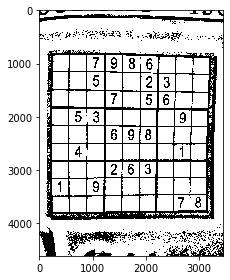

In [3]:
threshold_image = skimage.filters.threshold_niblack(grey_img, window_size=501, k=0.3)

niblack_result = np.where(grey_img < threshold_image, np.zeros((width, height)), 1)

skimage.io.imshow(niblack_result)
plt.show()

## Binarisation de Sauvola

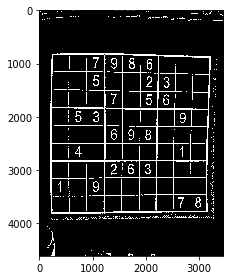

In [4]:
threshold_image = skimage.filters.threshold_sauvola(grey_img, window_size=71, k=0.1)

sauvola_result = np.where(grey_img < threshold_image, np.ones((width, height)), 0)

skimage.io.imshow(sauvola_result)
plt.show()

# Détection de la grille
## Filtrage de l'image

c:\Users\km169\Desktop\Cours\Data mining\Projet de session\sudoku-reader\env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


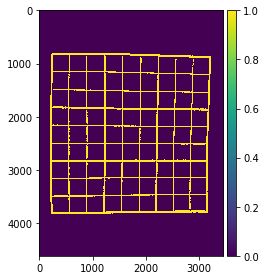

In [5]:
filtered_img = ndimage.binary_dilation(sauvola_result, iterations=3).astype(sauvola_result.dtype)

labeled_img, nb_labels = ndimage.label(filtered_img)

sizes = ndimage.sum(filtered_img, labeled_img, range(nb_labels + 1))
mask = sizes == max(sizes)

filtered_img = mask[labeled_img]
filtered_img = np.where(filtered_img == True, filtered_img, 0)
filtered_img = np.where(filtered_img == 0, filtered_img, 1)


skimage.io.imshow(filtered_img)

## Projections sur les différents axes

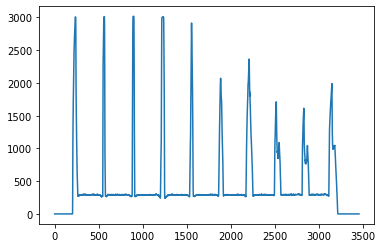

In [6]:
x_proj = filtered_img.sum(axis=0)
plt.plot(np.arange(len(x_proj)), x_proj)
plt.show()

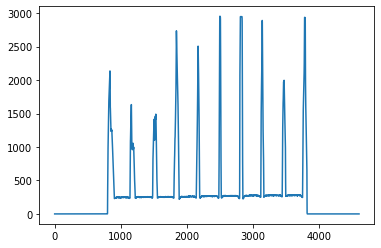

In [7]:
y_proj = filtered_img.sum(axis=1)
plt.plot(np.arange(len(y_proj)), y_proj)
plt.show()

## Reconnaissance de la grille

In [8]:
def clear_spikes(binary_picture: np.ndarray, spikes, axis=0):
    grid_width = spikes[-1]-spikes[0]
    margin = int(grid_width*0.025)
    proj = binary_picture.sum(axis=axis)
    for i in range(len(spikes)):
        spike = spikes[i]
        lower_bound = max(0, spike - margin)
        upper_bound = min(spike + margin, len(proj))
        spikes[i] = lower_bound + np.argmax(proj[lower_bound:upper_bound])
    return spikes

### Selon l'axe X

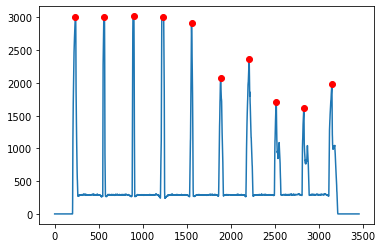

In [9]:
x_diff = np.diff(x_proj)
spikes = argrelextrema(x_diff, np.greater, order=int(len(x_diff)*.8*.05))[0] + 1

spikes = clear_spikes(filtered_img, spikes, axis=0)

# R&cupération des x plus grand pics
highest_spikes = spikes[np.argpartition(x_proj[spikes], -min(10, len(spikes)))[-min(10, len(spikes)):]]
x_spikes = np.sort(highest_spikes)

# Affichage de la nouvelle grille
plt.plot(np.arange(len(x_proj)), x_proj)
plt.plot(x_spikes, x_proj[x_spikes], 'ro')
plt.show()

### Selon l'axe Y

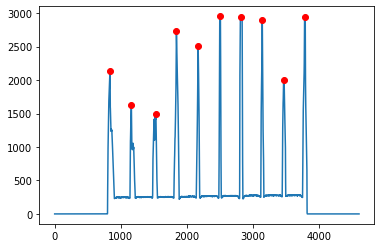

In [10]:
y_diff = np.diff(y_proj)
spikes = argrelextrema(y_diff, np.greater, order=int(len(y_diff)*.8*.05))[0] + 1

spikes = clear_spikes(filtered_img, spikes, axis=1)

# R&cupération des x plus grand pics
highest_spikes = spikes[np.argpartition(y_proj[spikes], -min(10, len(spikes)))[-min(10, len(spikes)):]]
y_spikes = np.sort(highest_spikes)

# Affichage de la nouvelle grille
plt.plot(np.arange(len(y_proj)), y_proj)
plt.plot(y_spikes, y_proj[y_spikes], 'ro')
plt.show()

## Prévisualisation de la grille

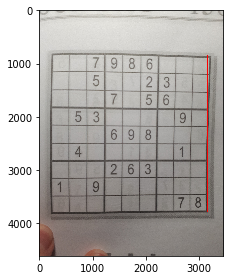

In [11]:

grid_preview = img.copy()

for i in range(len(y_spikes)):
    rr, cc = skimage.draw.line(y_spikes[i], x_spikes[0], y_spikes[i], x_spikes[-1])
    grid_preview[rr, cc] = [255, 0, 0]

for i in range(len(x_spikes)):
    rr, cc = skimage.draw.line(y_spikes[0], x_spikes[i], y_spikes[-1], x_spikes[i])
    grid_preview[rr, cc] = [255, 0, 0]

skimage.io.imshow(grid_preview)

# Isolation des cases

In [12]:
cases = list()


for i in range(len(y_spikes)-1):
    for j in range(len(x_spikes)-1):
        cases.append((x_spikes[j], x_spikes[j+1], y_spikes[i], y_spikes[i+1]))

print(f"{len(cases)} cases.")

81 cases.


## Détection des cases vides

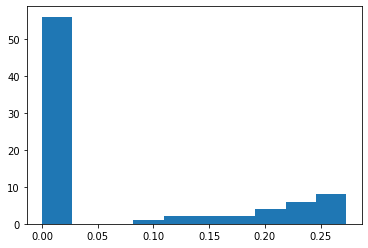

In [13]:
mean_list = list()

case_width = y_spikes[1]-y_spikes[0]
margin = int(case_width*0.2)

for coor in cases:
    bin_case = sauvola_result[coor[2] + margin:coor[3] - margin, coor[0] + margin:coor[1] - margin]
    mean_list.append(np.mean(bin_case.flatten()))

plt.hist(mean_list, 10)
plt.show()

25 cases avec des chiffres.


C:\Users\km169\AppData\Local\Temp/ipykernel_5260/1960776091.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


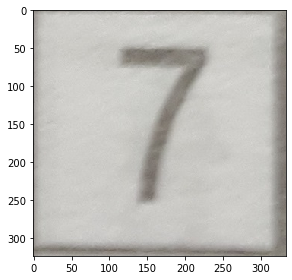

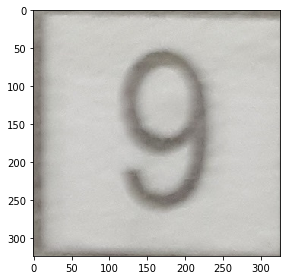

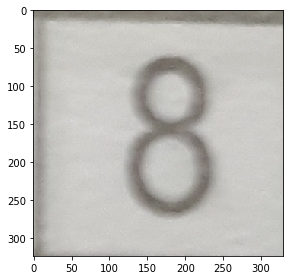

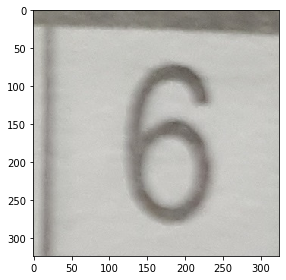

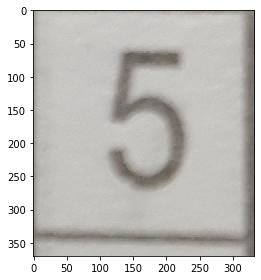

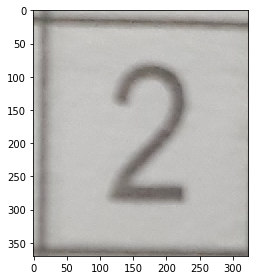

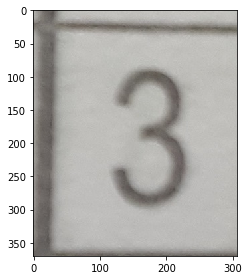

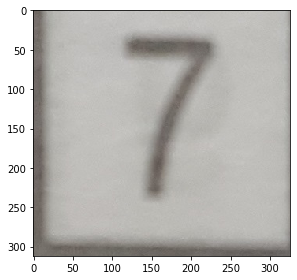

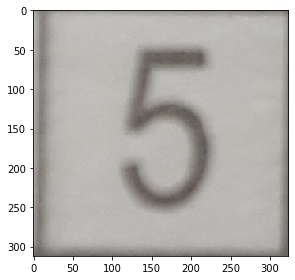

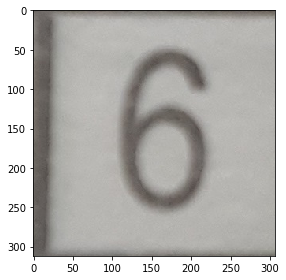

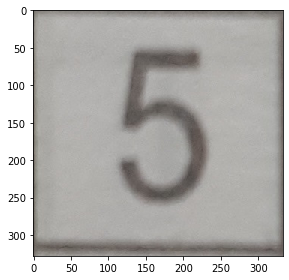

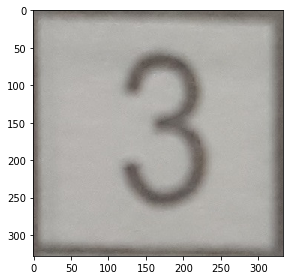

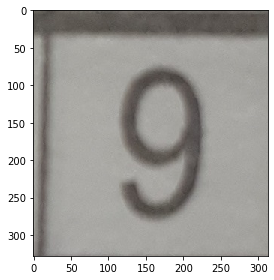

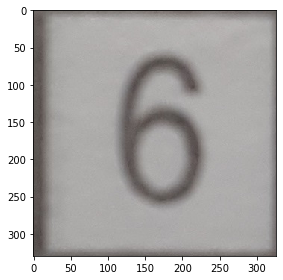

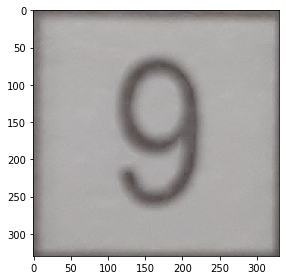

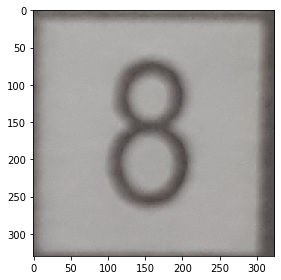

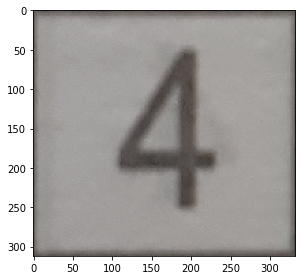

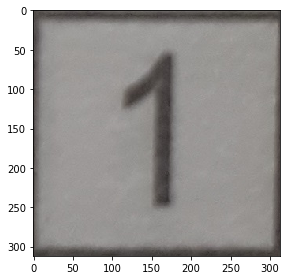

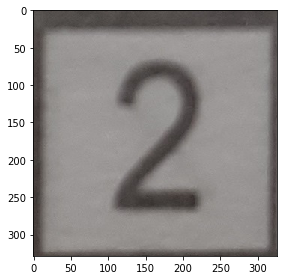

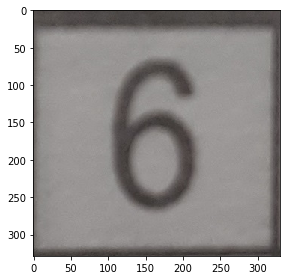

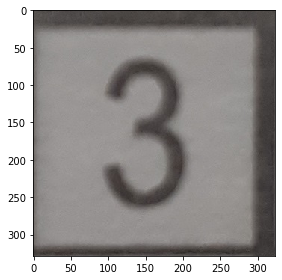

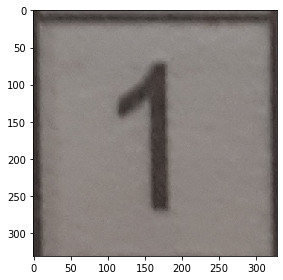

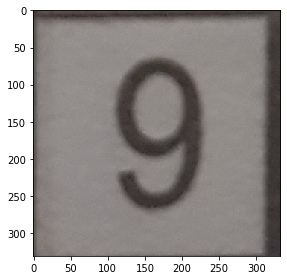

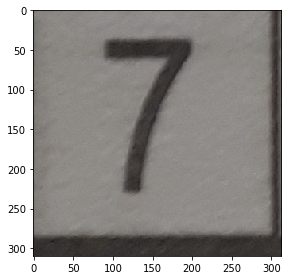

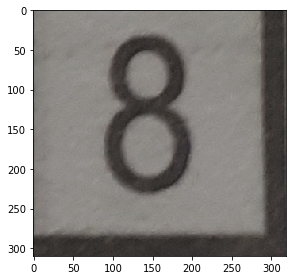

In [14]:
digits = list()
for i in range(len(mean_list)):
    if mean_list[i] > 0.05:
        digits.append(cases[i])

print(f"{len(digits)} cases avec des chiffres.")

for coor in digits:
    plt.figure()
    skimage.io.imshow(img[coor[2]:coor[3], coor[0]:coor[1]])
plt.show()